In [1]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import alphashape
from sklearn.neighbors import NearestNeighbors
import warnings

root = Tk()
root.withdraw()

# read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

# data define
target_mode = "US06"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]

original_df=train_df

# 選んだ特徴量だけ分析対象にする
selected_features = ['APSP','TRQCRKENG', 'NE']
print("selected_features:",selected_features)

#feature_vars

Unique Modes: ['F3kai2', 'HWY', 'JC08', 'L4F', 'NYCC', 'US06', 'WLTP']
selected_features: ['APSP', 'TRQCRKENG', 'NE']


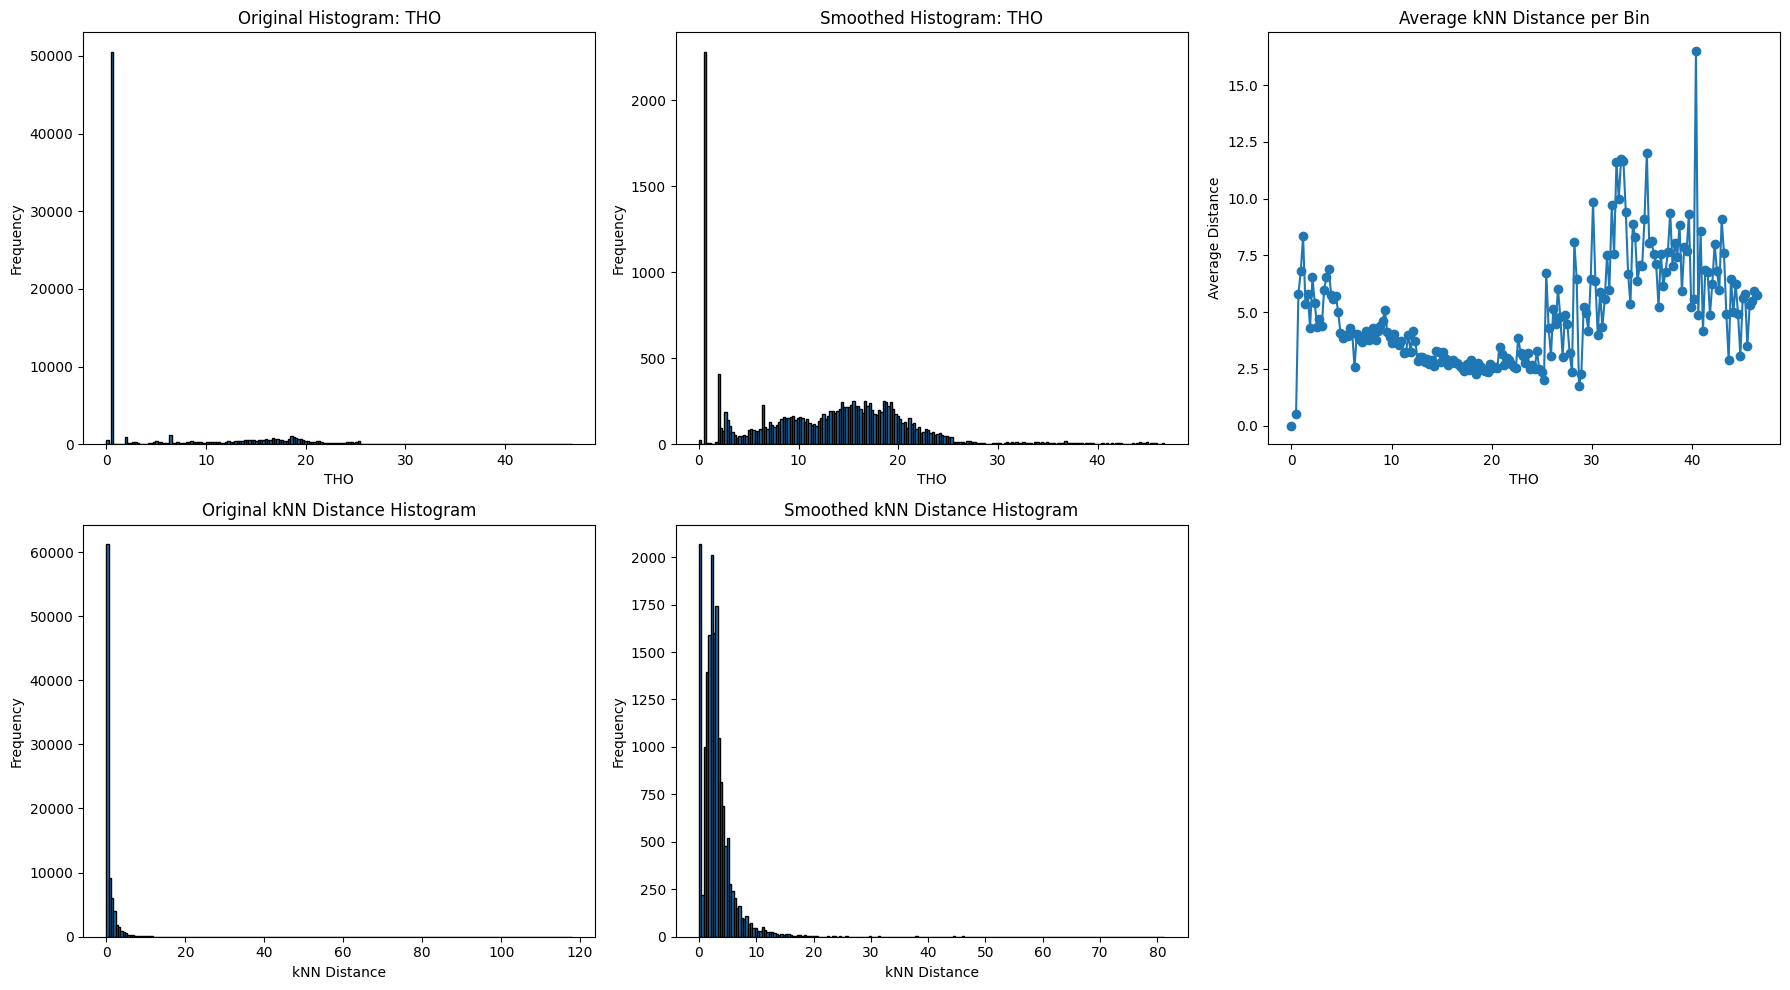

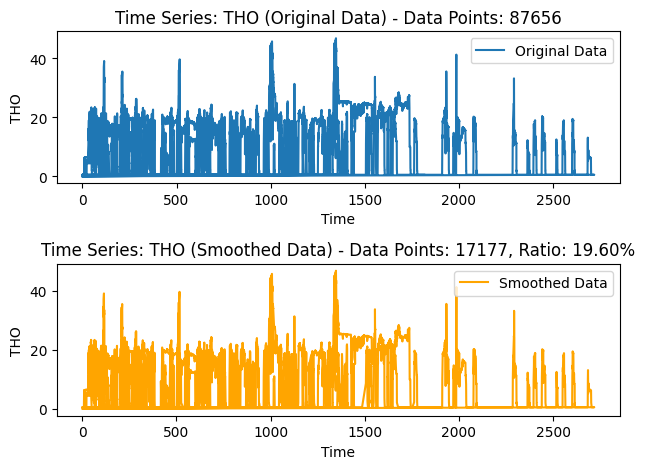

In [14]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# ビン分割数とcut-off閾値
n_bins = 200
threshold = 2500

# kNNの設定
k = 5

# original_dfに対しkNN distanceを計算して追加
original_df['knn_distance'] = None
nbrs_original = NearestNeighbors(n_neighbors=k).fit(original_df[selected_features + [target_variable]])
distances_original, _ = nbrs_original.kneighbors(original_df[selected_features + [target_variable]])
original_df['knn_distance'] = distances_original[:, 1]

train_df = original_df.copy()


# 第二最短距離のヒストグラムのためのビン範囲を定義
bin_range = np.linspace(train_df['knn_distance'].min(), train_df['knn_distance'].max(), n_bins + 1)

# データの平滑化
smoothed_df = pd.DataFrame()
for i in range(len(bin_range) - 1):
    bin_df = train_df[(train_df['knn_distance'] >= bin_range[i]) & (train_df['knn_distance'] < bin_range[i + 1])]
    if len(bin_df) > threshold:
        bin_df = bin_df.sample(n=threshold, random_state=42)
    smoothed_df = pd.concat([smoothed_df, bin_df])


# kNN距離を更新
smoothed_df['knn_distance'] = None
nbrs_smoothed = NearestNeighbors(n_neighbors=k).fit(smoothed_df[selected_features + [target_variable]])
distances_smoothed, _ = nbrs_smoothed.kneighbors(smoothed_df[selected_features + [target_variable]])
smoothed_df['knn_distance'] = distances_smoothed[:, 1]


# unique_modes と time でソート
sorted_df = pd.DataFrame()
for mode in unique_modes:
    mode_df = smoothed_df[smoothed_df['Mode'] == mode]
    mode_df = mode_df.sort_values(by='time')
    sorted_df = pd.concat([sorted_df, mode_df])


# csv出力
original_file_name = csv_file_path.split('/')[-1].split('.')[0]
sorted_file_name = original_file_name + f"_knn-smooth_bin{n_bins}_thr{threshold}.csv"
sorted_df.to_csv(sorted_file_name, index=False)

# データセット更新(ヒストグラム改善後)
train_df = sorted_df


# 目的変数のビン範囲を定義
target_bin_range = np.linspace(train_df[target_variable].min(), train_df[target_variable].max(), n_bins + 1)

# 各ビンに属するデータのknn_distanceの平均を計算
bin_avg_knn_distances = []

for i in range(len(target_bin_range) - 1):
    bin_df = train_df[(train_df[target_variable] >= target_bin_range[i]) & (train_df[target_variable] < target_bin_range[i + 1])]
    if not bin_df.empty:
        avg_distance = bin_df['knn_distance'].mean()
        bin_avg_knn_distances.append(avg_distance)
    else:
        bin_avg_knn_distances.append(None)


original_data_count = len(original_df[target_variable])
smoothed_data_count = len(train_df[target_variable])
data_ratio = smoothed_data_count / original_data_count * 100

# グラフ表示
plt.figure(figsize=(18, 10))

# 元の目的変数ヒストグラム
plt.subplot(2, 3, 1)
plt.hist(original_df[target_variable], bins=n_bins, edgecolor='black')
plt.title('Original Histogram: ' + target_variable)
plt.xlabel(target_variable)
plt.ylabel('Frequency')

# 改善後の目的変数ヒストグラム
plt.subplot(2, 3, 2)
plt.hist(train_df[target_variable], bins=n_bins, edgecolor='black')
plt.title('Smoothed Histogram: ' + target_variable)
plt.xlabel(target_variable)
plt.ylabel('Frequency')


# kNN距離の平均値
plt.subplot(2, 3, 3)
plt.plot(target_bin_range[:-1], bin_avg_knn_distances, marker='o')
plt.title('Average kNN Distance per Bin')
plt.xlabel(target_variable)
plt.ylabel('Average Distance')


# 元のkNN距離ヒストグラム
plt.subplot(2, 3, 4)
plt.hist(original_df['knn_distance'], bins=n_bins, edgecolor='black')
plt.title('Original kNN Distance Histogram')
plt.xlabel('kNN Distance')
plt.ylabel('Frequency')

# 改善後のkNN距離ヒストグラム
plt.subplot(2, 3, 5)
plt.hist(train_df['knn_distance'], bins=n_bins, edgecolor='black')
plt.title('Smoothed kNN Distance Histogram')
plt.xlabel('kNN Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 元データセット時系列
plt.subplot(2, 1, 1)
plt.plot(original_df['time'], original_df[target_variable], label='Original Data')
plt.title(f'Time Series: {target_variable} (Original Data) - Data Points: {original_data_count}')
plt.xlabel('Time')
plt.ylabel(target_variable)
plt.legend()

# 平滑化時系列
plt.subplot(2, 1, 2)
plt.plot(train_df['time'], train_df[target_variable], label='Smoothed Data', color='orange')
plt.title(f'Time Series: {target_variable} (Smoothed Data) - Data Points: {smoothed_data_count}, Ratio: {data_ratio:.2f}%')
plt.xlabel('Time')
plt.ylabel(target_variable)
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
from scipy.spatial import ConvexHull, Delaunay
import plotly.graph_objects as go
import numpy as np
import os

target_inclusion_rate = 1

# binary search
def find_optimal_layers(points, test_points, target_inclusion_rate):
    min_difference = float('inf')
    optimal_layers = 0
    
    lower_bound = 0
    upper_bound = 10

    while lower_bound <= upper_bound:
        num_layers = (lower_bound + upper_bound) // 2
        temp_points = points.copy()
        
        for _ in range(num_layers):
            hull = ConvexHull(temp_points)
            temp_points = np.delete(temp_points, hull.vertices, axis=0)
            
            if len(temp_points) == 0:
                break
        
        hull = ConvexHull(temp_points)
        deln = Delaunay(temp_points[hull.vertices])
        is_inside = deln.find_simplex(test_points) >= 0
        inclusion_rate = np.sum(is_inside) / len(test_points)
        
        difference = abs(target_inclusion_rate - inclusion_rate)
        
        if difference < min_difference:
            min_difference = difference
            optimal_layers = num_layers

        if inclusion_rate < target_inclusion_rate:
            upper_bound = num_layers - 1
        else:
            lower_bound = num_layers + 1
            
    return optimal_layers


# Prepare data
train_data_np = train_data[selected_features].to_numpy()
test_data_np = test_data[selected_features].to_numpy()
train_data_with_target = train_df[selected_features + [target_variable]]
points_with_target = train_data_with_target.to_numpy()

# Find the optimal layers
optimal_layers = find_optimal_layers(train_data_np, test_data_np, target_inclusion_rate)

# Remove the optimal layers
for _ in range(optimal_layers):
    hull = ConvexHull(points_with_target[:, :-1])  # 目的変数を除外してConvexHull
    points_with_target = np.delete(points_with_target, hull.vertices, axis=0)

points = points_with_target[:, :-1]

# final ConvexHull
final_hull = ConvexHull(points_with_target[:, :-1])
final_boundary_points = points_with_target[final_hull.vertices, :-1]

# テストデータの外挿判定
test_data_with_target = test_df[selected_features + [target_variable]].to_numpy()
deln = Delaunay(points_with_target[final_hull.vertices, :-1])
is_inside = deln.find_simplex(test_data_with_target[:, :-1]) >= 0
outsider_test_points = test_data_with_target[~is_inside]
real_inclusion = np.sum(is_inside)/len(test_data_np)*100

# 目標包含率を満たすfinal_fullでのtrain_dataをExport
train_data_inside_hull = points_with_target[deln.find_simplex(points_with_target[:, :-1]) >= 0]
df_train_data_inside_hull = pd.DataFrame(train_data_inside_hull, columns=selected_features + [target_variable])
df_train_data_inside_hull.to_excel(f"TrainData_inside_hull(Inclusion_{real_inclusion:.1f}%)_target-{target_mode}.xlsx", index=False)


# 外挿判定されたテストデータをExport
outsider_test_points_df = pd.DataFrame(outsider_test_points, columns=selected_features + [target_variable])
excel_filename = f'Outsider_Test_Points_(Inclusion_{real_inclusion:.1f}%)_target-{target_mode}.xlsx'
outsider_test_points_df.to_excel(excel_filename, index=False)



# test_data Export
excel_filename_test = f"TestData_{target_mode}.xlsx"

if not os.path.exists(excel_filename_test):
    test_df.to_excel(excel_filename_test, index=False)
else:
    print(f"{excel_filename_test} は既に存在するのでExcel-exportはスキップ")


if train_data_np.shape[1] == 3:
    # Plotting
    fig = go.Figure()

    # Plot original train data
    fig.add_trace(go.Scatter3d(x=train_data_np[:, 0],
                            y=train_data_np[:, 1],
                            z=train_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='green'),
                            name='Original Train Data'))

    # Plot original test data
    fig.add_trace(go.Scatter3d(x=test_data_np[:, 0],
                            y=test_data_np[:, 1],
                            z=test_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='red'),
                            name='Original Test Data'))

    # Plot boundary points after removing layers
    fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                            y=final_boundary_points[:, 1],
                            z=final_boundary_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='blue'),
                            name=f'Boundary Points (remove {optimal_layers} layers)'))

    # Plot outsider test points
    fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                            y=outsider_test_points[:, 1],
                            z=outsider_test_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='purple'),
                            name='Outsider Test Points'))

   # hull_mesh
    fig.add_trace(go.Mesh3d(x=points[:, 0],
                            y=points[:, 1],
                            z=points[:, 2],
                            i=final_hull.simplices[:, 0],
                            j=final_hull.simplices[:, 1],
                            k=final_hull.simplices[:, 2],
                            opacity=0.6,
                            color='orange'))

    # Axis labels
    fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                                yaxis_title=selected_features[1],
                                zaxis_title=selected_features[2]),
                    title=f'Convex Hull(Inclusion:{real_inclusion:.1f}%)_target-{target_mode}')

    # Save as HTML
    fig.write_html(f"Convex Hull(Inclusion_{real_inclusion:.1f}%)_target-{target_mode}.html")

else:
    print(f"{train_data_np.shape[1]}次元なので可視化しません")


TestData_US06.xlsx は既に存在するのでExcel-exportはスキップ


In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull, Delaunay
import itertools
import pyDOE2
from sklearn.neighbors import NearestNeighbors
import math

feature_ranges = {feature: (train_data[feature].min(), train_data[feature].max()) 
                    for feature in selected_features}

# 端部DOE
if len(selected_features) <= 6:
    # フルファクトリアル
    levels = [np.array([mn, mx]) for mn, mx in feature_ranges.values()]
    full_factorial_design = np.array(list(itertools.product(*levels)))
    experiment_design_df = pd.DataFrame(full_factorial_design, columns=selected_features)
else:
    # BBD
    num_factors = len(selected_features)
    bbd_design = pyDOE2.bbdesign(num_factors, center=1)
    scaled_design = np.zeros_like(bbd_design)
    for i, (feature, (min_val, max_val)) in enumerate(feature_ranges.items()):
        scaled_design[:, i] = bbd_design[:, i] * (max_val - min_val) / 2 + (max_val + min_val) / 2
    experiment_design_df = pd.DataFrame(scaled_design, columns=selected_features)

experiment_design_np = experiment_design_df.to_numpy()


def in_hull(point, hull):
    return hull.find_simplex(point) >=0

def lhs_outside_hull(num_samples, hull, feature_ranges):
    samples_outside_hull = []
    # num_samples分のサンプルが得られるまでループ
    while len(samples_outside_hull) < num_samples:
        # 一度にnum_samples分のサンプリングを行い、不足分を埋める
        lhs_samples = pyDOE2.lhs(len(feature_ranges), samples=num_samples, criterion='maximin')
        for sample in lhs_samples:
            if len(samples_outside_hull) >= num_samples:
                break  # 必要な数のサンプルが得られたらループを抜ける
            scaled_sample = np.array([fr[0] + (fr[1] - fr[0]) * s for fr, s in zip(feature_ranges.values(), sample)])
            if not in_hull(scaled_sample, hull):
                samples_outside_hull.append(scaled_sample)

    return samples_outside_hull


additional_samples = 200

# LHSサンプリング
hull = Delaunay(points[final_hull.vertices])
num_LHS_samples = math.ceil(additional_samples * 0.6)
LHS_samples = lhs_outside_hull(num_LHS_samples, hull, feature_ranges)
LHS_samples_np = np.array(LHS_samples)


#adaptive sampling
full_dataset_np = np.concatenate((train_data_np, experiment_design_np, LHS_samples_np))

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', n_jobs=-1).fit(full_dataset_np)
distances, _ = nbrs.kneighbors(full_dataset_np)

num_adaptive_samples = math.ceil(additional_samples * 0.4)

# データ密度が最も低い点からサンプリングする
low_density_points = np.argsort(-distances[:, 1])[:num_adaptive_samples]

adaptive_samples = np.zeros((num_adaptive_samples, full_dataset_np.shape[1]))
for i, point_index in enumerate(low_density_points):
    # サンプリングする点にノイズを加える
    sample = full_dataset_np[point_index] + np.random.normal(size=full_dataset_np.shape[1]) * distances[point_index, 1] * 0.5
    # 特徴量の範囲内にクリップする
    for j, feature in enumerate(selected_features):
        min_val, max_val = feature_ranges[feature]
        sample[j] = np.clip(sample[j], min_val, max_val)
    adaptive_samples[i] = sample


# Excel Export(Trainingは除く)
feature_names = selected_features
experiment_design_df['Category'] = 'edge DOE'

LHS_samples_df = pd.DataFrame(LHS_samples_np, columns=feature_names)
LHS_samples_df['Category'] = 'LHS'

adaptive_samples_df = pd.DataFrame(adaptive_samples, columns=feature_names)
adaptive_samples_df['Category'] = 'Adaptive'

all_samples_df = pd.concat([experiment_design_df, LHS_samples_df, adaptive_samples_df], ignore_index=True)
all_samples_df.to_excel(f'add_DOE_DataSet_(Inclusion_{real_inclusion:.1f}%).xlsx', index=False)


if train_data_np.shape[1] == 3:
    # Plot
    fig = go.Figure()

    # train data
    fig.add_trace(go.Scatter3d(x=train_data_np[:, 0],
                            y=train_data_np[:, 1],
                            z=train_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='green'),
                            name='Original Train Data'))

    # test data
    fig.add_trace(go.Scatter3d(x=test_data_np[:, 0],
                            y=test_data_np[:, 1],
                            z=test_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='red'),
                            name='Original Test Data'))

    # 境界点
    fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                            y=final_boundary_points[:, 1],
                            z=final_boundary_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='orange'),
                            name=f'Boundary Points (remove {optimal_layers} layers)'))

    # 外装判定テストデータ
    fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                            y=outsider_test_points[:, 1],
                            z=outsider_test_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='purple'),
                            name='Outsider Test Points'))

    # Convex hull
    fig.add_trace(go.Mesh3d(x=points[:, 0],
                            y=points[:, 1],
                            z=points[:, 2],
                            i=final_hull.simplices[:, 0],
                            j=final_hull.simplices[:, 1],
                            k=final_hull.simplices[:, 2],
                            opacity=0.4,
                            color='orange'))

    # End Point
    fig.add_trace(go.Scatter3d(x=experiment_design_np[:, 0],
                            y=experiment_design_np[:, 1],
                            z=experiment_design_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='black'),
                            name='EndPoint'))

    #LHS
    fig.add_trace(go.Scatter3d(
        x=LHS_samples_np[:, 0],
                                y=LHS_samples_np[:, 1],
                                z=LHS_samples_np[:, 2],
                                mode='markers',
                                marker=dict(size=4, color='blue'),
                                name='LHS Samples'))

    # Adaptive sampling
    fig.add_trace(go.Scatter3d(x=adaptive_samples[:, 0],
                            y=adaptive_samples[:, 1],
                            z=adaptive_samples[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='yellow'),
                            name='Adaptive Samples'))


    # Set axis labels
    fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                                yaxis_title=selected_features[1],
                                zaxis_title=selected_features[2]),
                    title=f'Convex Hull+DOE(Inclusion:{real_inclusion:.1f}%)_target-{target_mode}')


    # HTML
    fig.write_html(f"Convex Hull+DOE(Inclusion_{real_inclusion:.1f}%)_target-{target_mode}.html")

else:
    print(f"{train_data_np.shape[1]}次元なので可視化しません")

